In [1]:
### imports
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import joblib
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.preprocessing import LabelBinarizer, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Preprocessing

In [2]:
hotel_df = pd.read_csv('Hotel Reservations.csv')
hotel_df.drop(['Booking_ID'], inplace=True, axis=1)

In [3]:
categorical_vars = ['type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type']
numerical_vars = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'repeated_guest', 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
time_vars = ['arrival_year', 'arrival_month', 'arrival_date']

excluded_vars = ['arrival_year']

included_categorical_vars = [var for var in categorical_vars if var not in excluded_vars]
included_numerical_vars = [var for var in numerical_vars if var not in excluded_vars]
included_time_vars = [var for var in time_vars if var not in excluded_vars]

X = hotel_df.drop(['booking_status'] + excluded_vars, axis=1)
y = hotel_df['booking_status']

y_bin = LabelBinarizer().fit_transform(y)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=92)

### Neural Network

In [4]:
### load model
model_nn = tf.keras.models.load_model('Models/Model 1/hotel_reservation_1.h5', compile=False)
model_nn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
                loss=tf.keras.losses.binary_crossentropy, 
                metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [5]:
### load feature transformer
scaler = pickle.load(open('Models/scaler.pkl', 'rb'))

In [6]:
def nn_predict(x):
    '''
    Takes an input, x, and uses the neural network to predict if the hotel
    reservation is cancelled.
    
    ------------
    Input
    ------------
    The input must be an (n x 16) numpy array or an (n x 16) subset of a named DataFrame.

    If the input is a numpy array, then order of the variables must be:

    'type_of_meal_plan', 'required_car_parking_space', 'room_type_reserved', 'market_segment_type', 'no_of_adults', 'no_of_children', 
    'no_of_weekend_nights', 'no_of_week_nights', 'lead_time', 'repeated_guest', 'no_of_previous_cancellations', 
    'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests', 'arrival_month', 'arrival_date'

    ------------
    Output
    ------------
    The output is either 0 or 1.
    0: 'Cancelled'
    1: 'Not_Cancelled'
    
    '''
    ### transform input
    x_scaled = scaler.transform(x)

    ### make prediction
    threshold = 0.5
    pred = model_nn.predict(x_scaled)
    pred = np.where(pred >= threshold, 1, 0)

    return pred

227/227 [==============================] - 0s 619us/step
Training Accuracy:  88.58%
Testing Accuracy:  87.17%
              precision    recall  f1-score   support

           0       0.73      0.90      0.81      7734
           1       0.96      0.88      0.92     21286

    accuracy                           0.89     29020
   macro avg       0.85      0.89      0.86     29020
weighted avg       0.90      0.89      0.89     29020



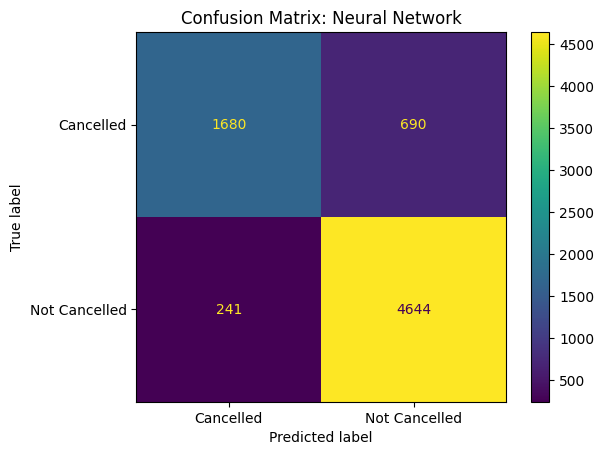

In [7]:
### determine predicted values
nn_train_pred = nn_predict(X_train)
nn_test_pred = nn_predict(X_test)

### accuracy
nn_train_acc = accuracy_score(y_train, nn_train_pred)
nn_test_acc = accuracy_score(y_test, nn_test_pred)
print(f"Training Accuracy:  {100*nn_train_acc:.2f}%")
print(f"Testing Accuracy:  {100*nn_test_acc:.2f}%")
print(classification_report(nn_train_pred, y_train))

nn_cm = confusion_matrix(y_test, nn_test_pred)
nn_cm_disp = ConfusionMatrixDisplay(nn_cm, display_labels=['Cancelled', 'Not Cancelled'])
nn_cm_disp.plot()
plt.title('Confusion Matrix: Neural Network')
plt.show()

### Naive Bayes

Training Accuracy:  67.15%
Testing Accuracy:  67.33%
              precision    recall  f1-score   support

           0       0.01      0.46      0.02       208
           1       0.99      0.67      0.80     28812

    accuracy                           0.67     29020
   macro avg       0.50      0.56      0.41     29020
weighted avg       0.99      0.67      0.80     29020



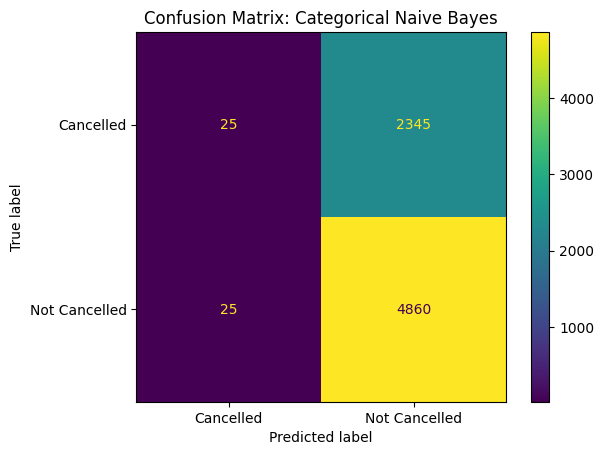

In [8]:
###############################
### Naive Bayes Categorical ###
###############################

oe = OrdinalEncoder()
X_nb_cat_scaled = oe.fit_transform(X_train[included_categorical_vars])
clf = CategoricalNB()
clf.fit(X_nb_cat_scaled, y_train.ravel())


def NB_cat(x):
    x_scaled = oe.transform(x[included_categorical_vars])
    pred = clf.predict(x_scaled)
    pred = pred.reshape(-1, 1)
    return pred

### determine predicted values
nb_cat_train_pred = NB_cat(X_train)
nb_cat_test_pred = NB_cat(X_test)

### accuracy
nb_cat_train_acc = accuracy_score(y_train, nb_cat_train_pred)
nb_cat_test_acc = accuracy_score(y_test, nb_cat_test_pred)
print(f"Training Accuracy:  {100*nb_cat_train_acc:.2f}%")
print(f"Testing Accuracy:  {100*nb_cat_test_acc:.2f}%")
print(classification_report(nb_cat_train_pred, y_train))

nb_cat_cm = confusion_matrix(y_test, nb_cat_test_pred)
nb_cat_cm_disp = ConfusionMatrixDisplay(nb_cat_cm, display_labels=['Cancelled', 'Not Cancelled'])
nb_cat_cm_disp.plot()
plt.title('Confusion Matrix: Categorical Naive Bayes')
plt.show()

Training Accuracy:  37.22%
Testing Accuracy:  37.13%
              precision    recall  f1-score   support

           0       1.00      0.34      0.51     27713
           1       0.07      0.99      0.12      1307

    accuracy                           0.37     29020
   macro avg       0.53      0.67      0.32     29020
weighted avg       0.96      0.37      0.49     29020



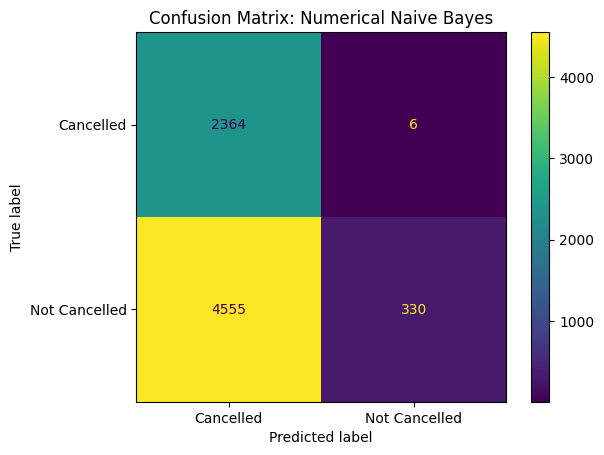

In [9]:
#############################
### Naive Bayes Numerical ###
#############################

scaler_nb_num = StandardScaler()
X_nb_num_scaled = scaler_nb_num.fit_transform(X_train[included_numerical_vars])
clf_num = GaussianNB()
clf_num.fit(X_nb_num_scaled, y_train.ravel())

def NB_num(x):
    x_scaled = scaler_nb_num.transform(x[included_numerical_vars])
    pred = clf_num.predict(x_scaled)
    pred = pred.reshape(-1, 1)
    return pred

### determine predicted values
nb_num_train_pred = NB_num(X_train)
nb_num_test_pred = NB_num(X_test)

### accuracy
nb_num_train_acc = accuracy_score(y_train, nb_num_train_pred)
nb_num_test_acc = accuracy_score(y_test, nb_num_test_pred)
print(f"Training Accuracy:  {100*nb_num_train_acc:.2f}%")
print(f"Testing Accuracy:  {100*nb_num_test_acc:.2f}%")
print(classification_report(nb_num_train_pred, y_train))

nb_num_cm = confusion_matrix(y_test, nb_num_test_pred)
nb_num_cm_disp = ConfusionMatrixDisplay(nb_num_cm, display_labels=['Cancelled', 'Not Cancelled'])
nb_num_cm_disp.plot()
plt.title('Confusion Matrix: Numerical Naive Bayes')
plt.show()

### Decision Tree

#### Pre-Pruned

In [10]:
dt_pre = joblib.load('Decision Trees/DT_pre.joblib')

Training Accuracy:  89.09%
Testing Accuracy:  87.39%
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      8948
           1       0.93      0.91      0.92     20072

    accuracy                           0.89     29020
   macro avg       0.87      0.88      0.87     29020
weighted avg       0.89      0.89      0.89     29020



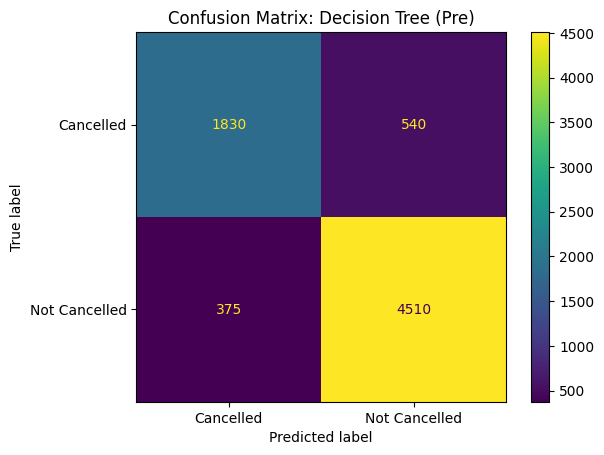

In [11]:
def DecisionTree_Pre(x):
    x_scaled = scaler.transform(x)
    pred = dt_pre.predict(x_scaled)
    pred = pred.reshape(-1, 1)
    return pred

### determine predicted values
dt_pre_train_pred = DecisionTree_Pre(X_train)
dt_pre_test_pred = DecisionTree_Pre(X_test)

### accuracy
dt_pre_train_acc = accuracy_score(y_train, dt_pre_train_pred)
dt_pre_test_acc = accuracy_score(y_test, dt_pre_test_pred)
print(f"Training Accuracy:  {100*dt_pre_train_acc:.2f}%")
print(f"Testing Accuracy:  {100*dt_pre_test_acc:.2f}%")
print(classification_report(dt_pre_train_pred, y_train))

dt_pre_cm = confusion_matrix(y_test, dt_pre_test_pred)
dt_pre_cm_disp = ConfusionMatrixDisplay(dt_pre_cm, display_labels=['Cancelled', 'Not Cancelled'])
dt_pre_cm_disp.plot()
plt.title('Confusion Matrix: Decision Tree (Pre)')
plt.show()

#### Post-Pruned

In [12]:
dt_post = joblib.load('Decision Trees/DT_post.joblib')

Training Accuracy:  90.98%
Testing Accuracy:  88.08%
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      8734
           1       0.95      0.92      0.93     20286

    accuracy                           0.91     29020
   macro avg       0.89      0.91      0.90     29020
weighted avg       0.91      0.91      0.91     29020



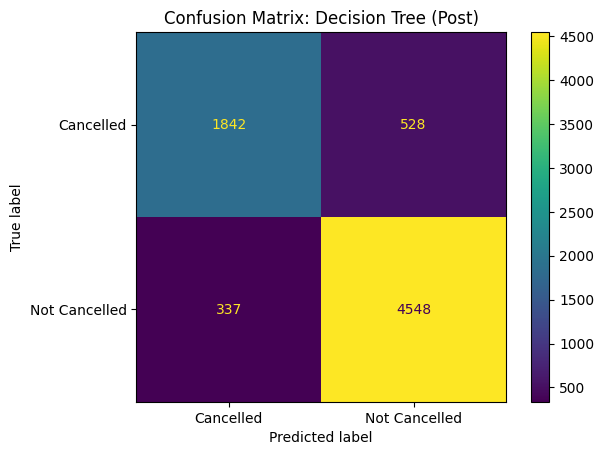

In [13]:
def DecisionTree_Post(x):
    x_scaled = scaler.transform(x)
    pred = dt_post.predict(x_scaled)
    pred = pred.reshape(-1, 1)
    return pred

### determine predicted values
dt_post_train_pred = DecisionTree_Post(X_train)
dt_post_test_pred = DecisionTree_Post(X_test)

### accuracy
dt_post_train_acc = accuracy_score(y_train, dt_post_train_pred)
dt_post_test_acc = accuracy_score(y_test, dt_post_test_pred)
print(f"Training Accuracy:  {100*dt_post_train_acc:.2f}%")
print(f"Testing Accuracy:  {100*dt_post_test_acc:.2f}%")
print(classification_report(dt_post_train_pred, y_train))

dt_post_cm = confusion_matrix(y_test, dt_post_test_pred)
dt_post_cm_disp = ConfusionMatrixDisplay(dt_post_cm, display_labels=['Cancelled', 'Not Cancelled'])
dt_post_cm_disp.plot()
plt.title('Confusion Matrix: Decision Tree (Post)')
plt.show()

#### Pre- & Post-Pruned

In [14]:
dt_both = joblib.load('Decision Trees/DT_both.joblib')

Training Accuracy:  88.71%
Testing Accuracy:  87.42%
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      8809
           1       0.93      0.90      0.92     20211

    accuracy                           0.89     29020
   macro avg       0.86      0.88      0.87     29020
weighted avg       0.89      0.89      0.89     29020



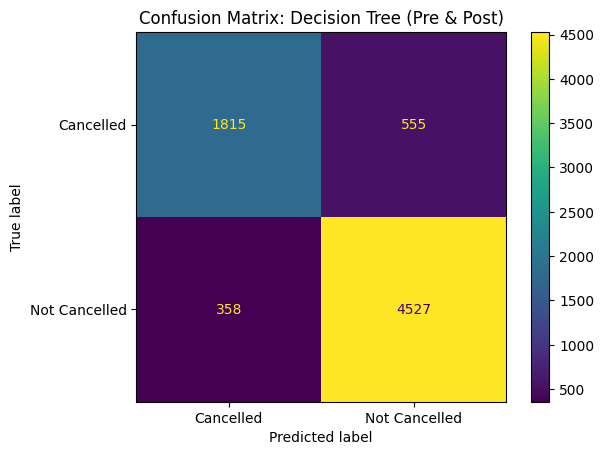

In [15]:
def DecisionTree_Both(x):
    x_scaled = scaler.transform(x)
    pred = dt_both.predict(x_scaled)
    pred = pred.reshape(-1, 1)
    return pred

### determine predicted values
dt_both_train_pred = DecisionTree_Both(X_train)
dt_both_test_pred = DecisionTree_Both(X_test)

### accuracy
dt_both_train_acc = accuracy_score(y_train, dt_both_train_pred)
dt_both_test_acc = accuracy_score(y_test, dt_both_test_pred)
print(f"Training Accuracy:  {100*dt_both_train_acc:.2f}%")
print(f"Testing Accuracy:  {100*dt_both_test_acc:.2f}%")
print(classification_report(dt_both_train_pred, y_train))

dt_both_cm = confusion_matrix(y_test, dt_both_test_pred)
dt_both_cm_disp = ConfusionMatrixDisplay(dt_both_cm, display_labels=['Cancelled', 'Not Cancelled'])
dt_both_cm_disp.plot()
plt.title('Confusion Matrix: Decision Tree (Pre & Post)')
plt.show()